# TOPIC MODELING

#### References: authors of the Script (C) Elisa Michelet, and Germans Savcisens (C).
Url containing script: https://github.com/arobaselisa/industrial-west, https://github.com/carlomarxdk/topic_modelling

# 1. Import the data

In [118]:
!pip install tomotopy
!pip install wordcloud

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 160.8/160.8 kB 4.3 MB/s eta 0:00:00


Loading all modules needed for creating the topic model:

In [3]:
import tomotopy as tp
import pandas as pd
import time
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from random import randrange
import spacy
import unidecode
import helpers
import nltk

sns.set_style("whitegrid")


Loading the spacy language model:

In [4]:
import sys
!{sys.executable} -m spacy download en_core_web_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 36.6 MB/s eta 0:00:0000:0100:01
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [143]:
data = pd.read_csv("updated_data.csv")
START_DATE = pd.to_datetime("1870-01-01") ## Articles on this date WILL be included
END_DATE = pd.to_datetime("1881-01-01") ## Articles on this date WON't be included 
SPACY_LANGUAGE = "en_core_web_sm" ## To change according to the corpus, french : fr_core_news_sm
COUNTRY = "US"
LANG = "en"


# 2. Data Processing

In [127]:

data["year"] = pd.to_numeric(data["year"],
                              errors="ignore")
print("Analysisng %d speeches" % len(data))
print("Dropping %d speeches" % data["year"].isna().sum())
data = data.dropna(subset=["year"]).copy()
data["year"] = data["year"].map(lambda y : y if y > 0 else y)
data["year_formatted"] = (data["year"] + 1900).map(lambda y : "%d-01-01" % (int(y) if y < 2000 else int(y) - 1900))
data["year-speech-held"] = pd.to_datetime(data["year_formatted"])

Analysisng 3247 speeches
Dropping 0 speeches


In [91]:
# Function to convert year format
def convert_year(year):
    if pd.isnull(year):
        return year
    elif isinstance(year, float):
        if year == 2006.0:
            return "2006"
        elif 60 <= year <= 99:
            return str(int(year) + 1900)
        else:
            return str(int(year) + 2000)
    else:
        return year

# Apply the conversion function to the 'year' column
data['year'] = data['year'].apply(convert_year)

# Define the fileid values and the corresponding years
fileid1 = 'jfkberliner'
year1 = '1963'

fileid2 = 'jfkinaugural'
year2 = '1961'

# Update the 'year' column for the selected rows
data.loc[data['fileid'] == fileid1, 'year'] = year1
data.loc[data['fileid'] == fileid2, 'year'] = year2

# Print the updated rows
print(data.loc[data['fileid'].isin([fileid1, fileid2])])

# Print the updated dataset
print(data.head())

max_year = data["year"].max()
print("Maximum year-speech-held:", max_year)

Empty DataFrame
Columns: [party, fileid, name, content, year, year_formatted, year-speech-held, topics, loose_topics, topic_idx, topic_dist]
Index: []
  party        fileid        name   
0   rep     akeyes-95  Alan_Keyes  \
1   rep     akeyes-98  Alan_Keyes   
2   rep  akeyes1-2-00  Alan_Keyes   
3   rep  akeyes1-6-96  Alan_Keyes   
4   rep  akeyes1-6-98  Alan_Keyes   

                                             content  year year_formatted   
0  We who are Christians usually think about Chri...  1995     1995-01-01  \
1  It is a very great honor and pleasure for me t...  1998     1998-01-01   
2  Thank you . Praise God . Thank you very much ....  2000     1900-01-01   
3  Thank you . Thank you . Praise God . Thank you...  1996     1996-01-01   
4  Thank you very much , God bless you . Unaccust...  1998     1998-01-01   

  year-speech-held topics  loose_topics  topic_idx   
0       1995-01-01     []     [1, 7, 9]         14  \
1       1998-01-01     []     [6, 7, 8]         14   
2

# 3. Topic Modelling

In [144]:
print("Create corpus for tp model...")
_, corpus = helpers.create_corpus(data, SPACY_LANGUAGE) #.sample(2000)
print("Done !")

Create corpus for tp model...
Runtime: 0.59 seconds || Completed: 1 of 3247
Runtime: 89.28 seconds || Completed: 501 of 3247
Runtime: 182.10 seconds || Completed: 1001 of 3247
Runtime: 256.40 seconds || Completed: 1501 of 3247
Runtime: 329.46 seconds || Completed: 2001 of 3247
Runtime: 422.25 seconds || Completed: 2501 of 3247
Runtime: 524.88 seconds || Completed: 3001 of 3247
Done !


* The code trains and evaluates topic models with different combinations of k1 and k2 parameters.
* k1 and k2 control the quality of clusters generated by the PAM algorithm.
* The code loops through different values of k1 and k2, trains a PAM model with each combination, and evaluates the coherence score of each trained model.
* The combinations of k1 and k2 and their corresponding coherence scores are saved in lists.
* The purpose of this code is to find the combination of k1 and k2 that produces the highest coherence score.

In [145]:
###########################################
###### You should change only this
k1_max = 4 ###(min 1) if k1_max - 1 == best k1
k2_max = 15
### k2 should always be higher than k1 (min 1)
####################
params = []
scores = []
num_iter = 0
max_iter = 0
for k1 in range(1, k1_max):
    for k2 in range(k1,k2_max):
        max_iter +=1
        
start = time.time()
for k1 in range(1, k1_max):
    for k2 in range(k1,k2_max):
        num_iter+=1
        model = tp.PAModel(tw=tp.TermWeight.IDF, min_df=10, rm_top=10, k1=k1, k2=k2, corpus=corpus, seed=0)
        model.train(500, workers=-1)
        score = tp.coherence.Coherence(model, coherence="c_v").get_score() #try with 'u_mass' instead of 'c_v' 
        params.append((k1,k2))
        scores.append(score)
        print("Runtime: %.2f seconds" %(time.time() - start), "|| Number of Searches: %s out of  %s" %(num_iter, max_iter))

/var/folders/2p/g46wblnn5yx00gf4gdw076yw0000gn/T/ipykernel_81764/1415164828.py:20: RuntimeWarning: The training result may differ even with fixed seed if `workers` != 1.
  model.train(500, workers=-1)


Runtime: 71.64 seconds || Number of Searches: 1 out of  39
Runtime: 150.72 seconds || Number of Searches: 2 out of  39
Runtime: 236.39 seconds || Number of Searches: 3 out of  39
Runtime: 330.86 seconds || Number of Searches: 4 out of  39
Runtime: 428.07 seconds || Number of Searches: 5 out of  39
Runtime: 524.44 seconds || Number of Searches: 6 out of  39
Runtime: 627.85 seconds || Number of Searches: 7 out of  39
Runtime: 738.98 seconds || Number of Searches: 8 out of  39
Runtime: 857.89 seconds || Number of Searches: 9 out of  39
Runtime: 982.52 seconds || Number of Searches: 10 out of  39
Runtime: 1112.81 seconds || Number of Searches: 11 out of  39
Runtime: 1237.57 seconds || Number of Searches: 12 out of  39
Runtime: 1321.67 seconds || Number of Searches: 13 out of  39
Runtime: 1411.16 seconds || Number of Searches: 14 out of  39
Runtime: 1474.75 seconds || Number of Searches: 15 out of  39
Runtime: 1544.67 seconds || Number of Searches: 16 out of  39
Runtime: 1614.76 seconds || 

(BEST MODEL) k1=3 k2=14 coherence=0.84


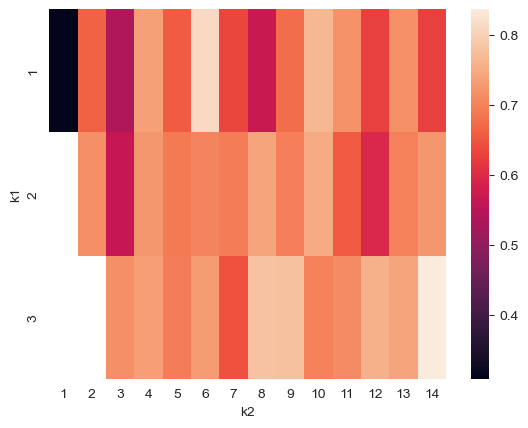

In [146]:
best_params = np.argmax(scores)
print("(BEST MODEL) k1=%s k2=%s coherence=%.2f"  %(params[best_params][0], params[best_params][1],  scores[best_params]))

data_params = pd.DataFrame(data={'k1':list(zip(*params))[0], 'k2':list(zip(*params))[1], 'score':scores})
data_params = data_params.pivot(index='k1', columns='k2', values='score')
sns.heatmap(data_params)
plt.show()

**1. Choose the best parameters**

In [177]:
#################################################
### Set the best model
best_k1 = params[best_params][0] 
best_k2 = params[best_params][1] 
model = tp.PAModel(tw=tp.TermWeight.IDF, min_cf=5, k1=best_k1, k2=best_k2, corpus=corpus, seed=0)
#model = tp.PAModel(tw=tp.TermWeight.IDF, min_cf=5, k1=2, k2=11, corpus=corpus, seed=0)
model.burn_in=100
model.train(5000, workers=-1)

/var/folders/2p/g46wblnn5yx00gf4gdw076yw0000gn/T/ipykernel_81764/2530361018.py:8: RuntimeWarning: The training result may differ even with fixed seed if `workers` != 1.
  model.train(5000, workers=-1)


In [178]:
score = tp.coherence.Coherence(model, coherence="c_v").get_score() #try with 'u_mass' instead of 'c_v' 
print(score)

0.7280561695496242


burn 50 train 1000 coh 0.70

In [191]:
model.save("/Users/laurachristoph/Library/CloudStorage/OneDrive-UniversitätZürichUZH/CL/03_F23_TextAnalytics/03_F23_TextAnalytics_TopicModel_Speeches/f23_textanalytics_topicmodeling/model_k1-3_k2-14_co0,728.bin")

In [135]:
model = tp.PAModel.load("/Users/laurachristoph/Library/CloudStorage/OneDrive-UniversitätZürichUZH/CL/03_F23_TextAnalytics/03_F23_TextAnalytics_TopicModel_Speeches/f23_textanalytics_topicmodeling/model_c.bin")

**2. Print all the topics**

In [180]:
#############################################
#### Topics gonna be here 
# Create an empty dictionary to store the topics
topics_dict = {}

for k in range(best_k2):
    print('Topic #{}'.format(k))
    print("\t", ["%s * %.4f" % (w,f) for w, f in model.get_topic_words(k)])
    # Store the words in a list
    topic_words = {w for w,f in model.get_topic_words(k)}

    # Add the topic to the dictionary
    topics_dict[k] = topic_words
        

Topic #0
	 ['teacher * 0.0112', 'student * 0.0103', 'school * 0.0095', 'education * 0.0064', 'science * 0.0061', 'college * 0.0053', 'classroom * 0.0042', 'math * 0.0038', 'graduate * 0.0038', 'university * 0.0035']
Topic #1
	 ['israel * 0.0055', 'peace * 0.0054', 'democracy * 0.0052', 'europe * 0.0050', 'trade * 0.0047', 'africa * 0.0047', 'nato * 0.0044', 'nuclear * 0.0042', 'global * 0.0041', 'minister * 0.0039']
Topic #2
	 ['inflation * 0.0066', 'soviet * 0.0061', 'liberal * 0.0055', 'opponent * 0.0052', 'taxis * 0.0049', 'mondale * 0.0043', 'spending * 0.0043', 'nicaragua * 0.0041', 'rate * 0.0039', 'sandinista * 0.0030']
Topic #3
	 ['iraq * 0.0116', 'terrorist * 0.0114', 'military * 0.0066', 'enemy * 0.0061', 'iraqi * 0.0059', 'terror * 0.0054', 'veteran * 0.0053', 'afghanistan * 0.0050', 'attack * 0.0050', 'force * 0.0041']
Topic #4
	 ['kid * 0.0091', 'healthy * 0.0076', 'team * 0.0072', 'food * 0.0065', 'coach * 0.0061', 'game * 0.0050', 'player * 0.0043', 'obesity * 0.0041', '

These are our word clouds:

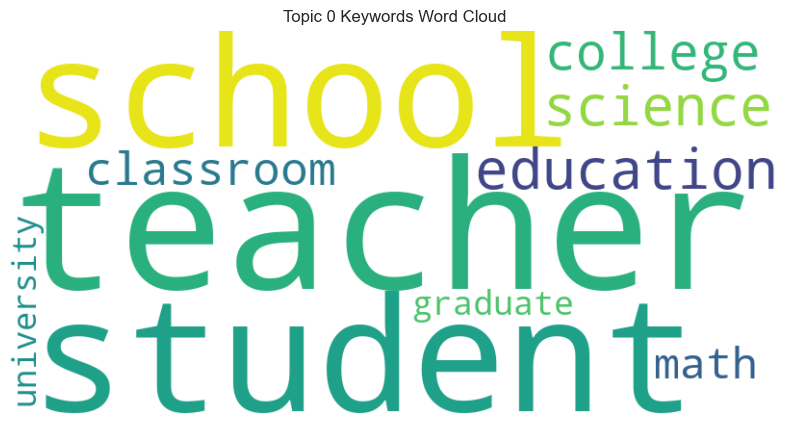

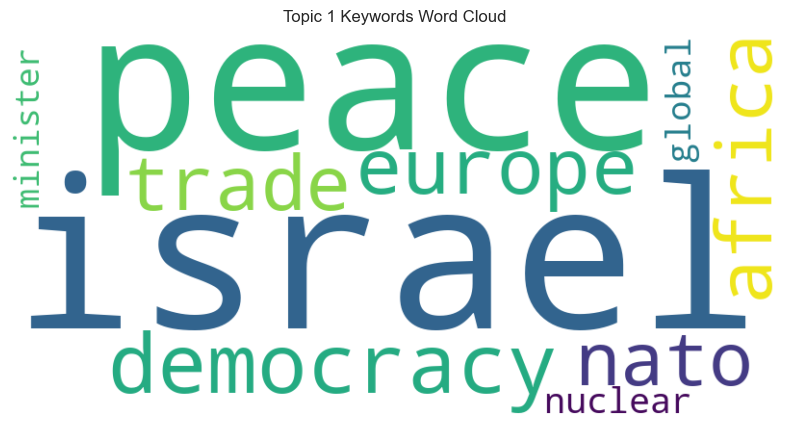

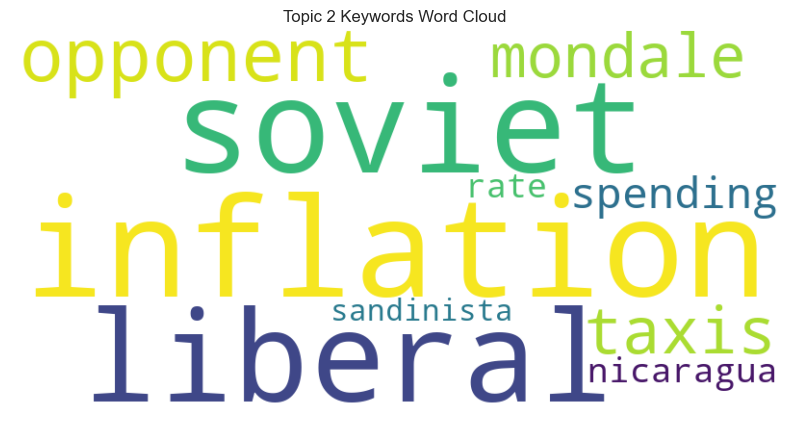

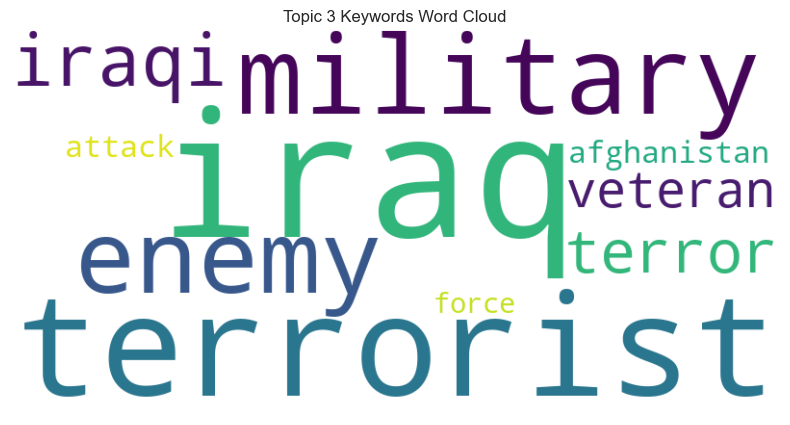

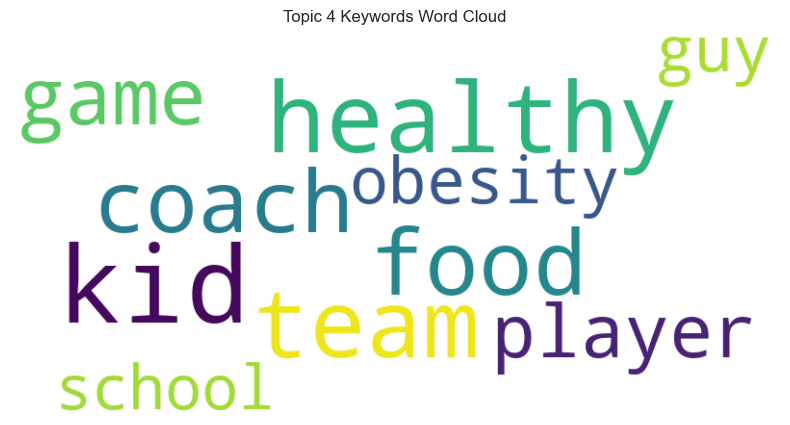

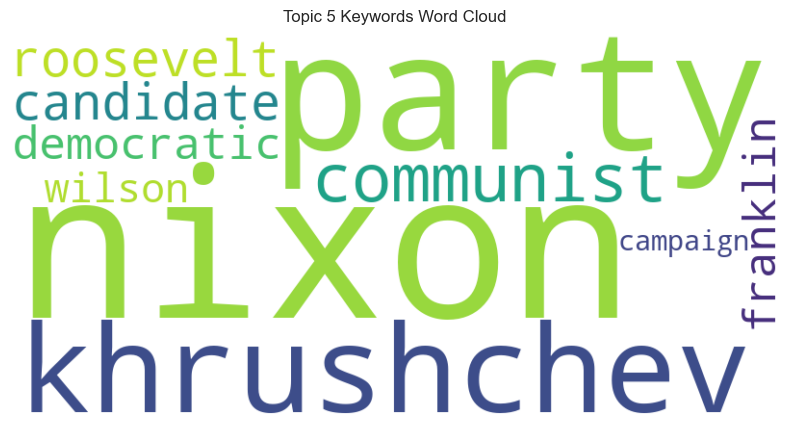

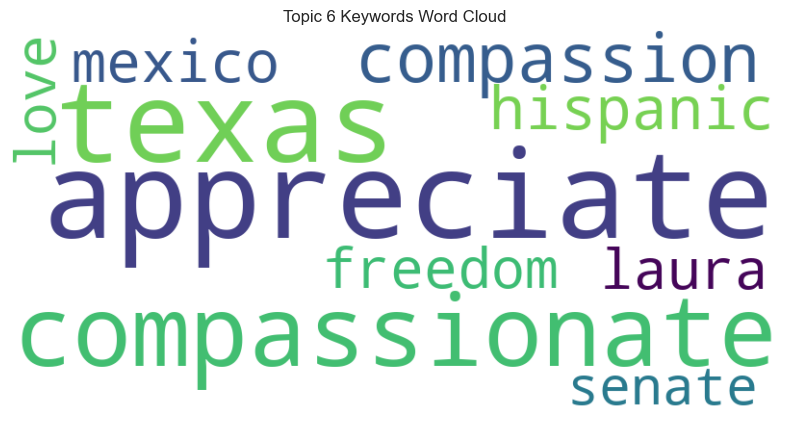

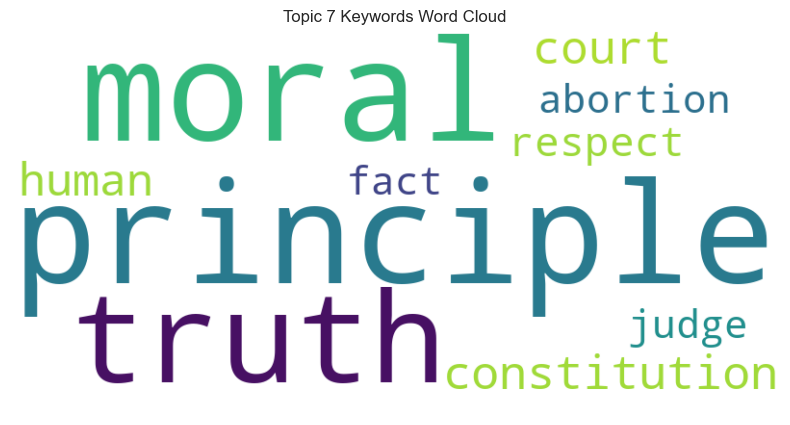

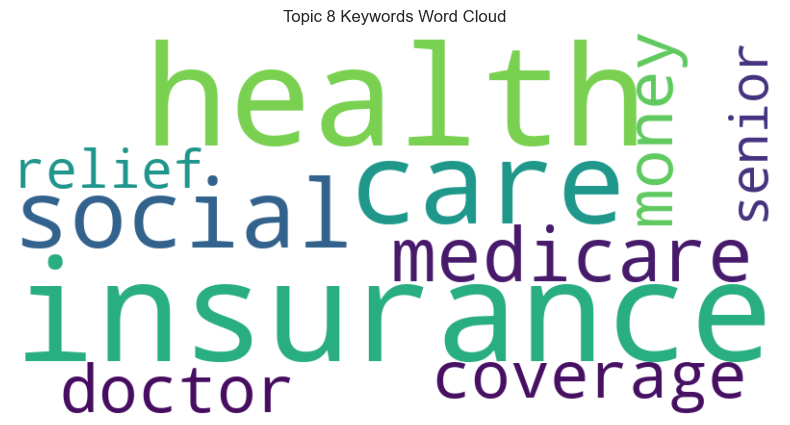

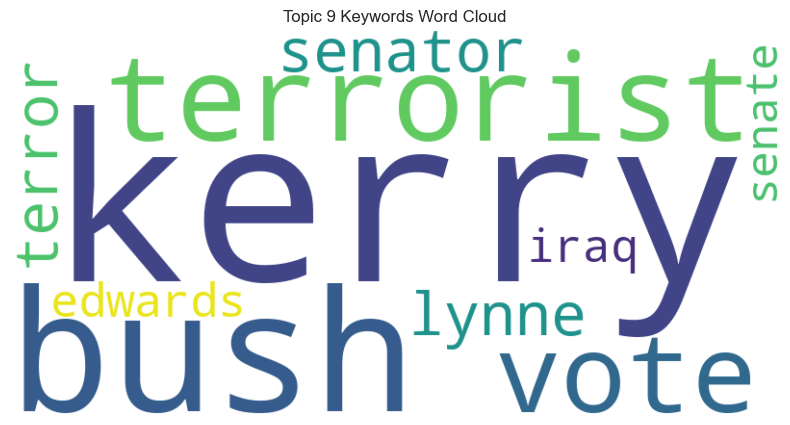

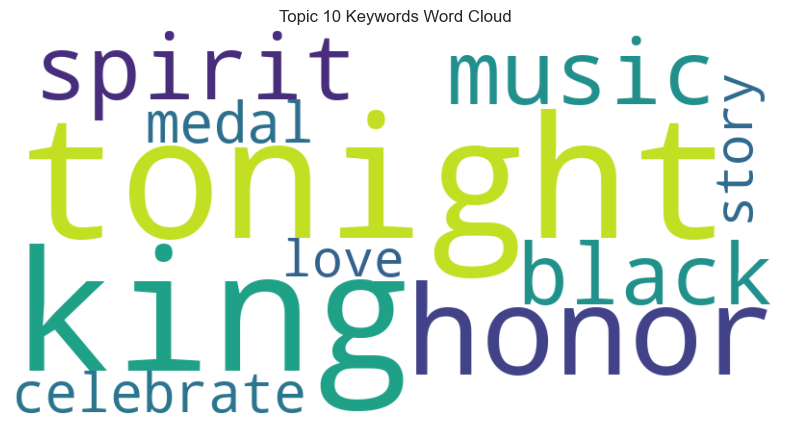

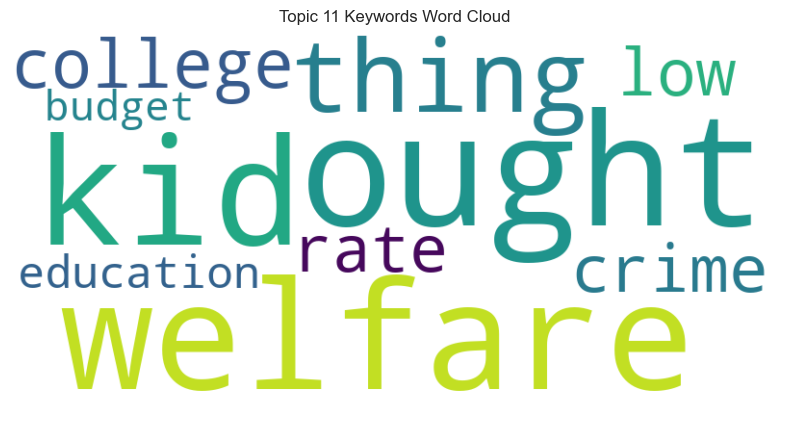

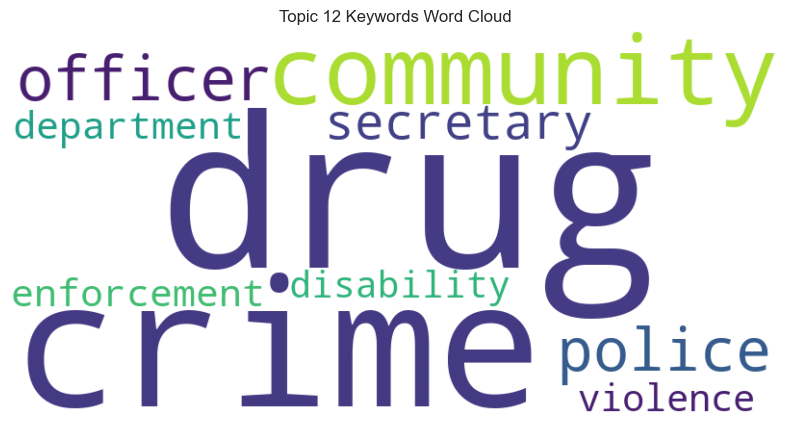

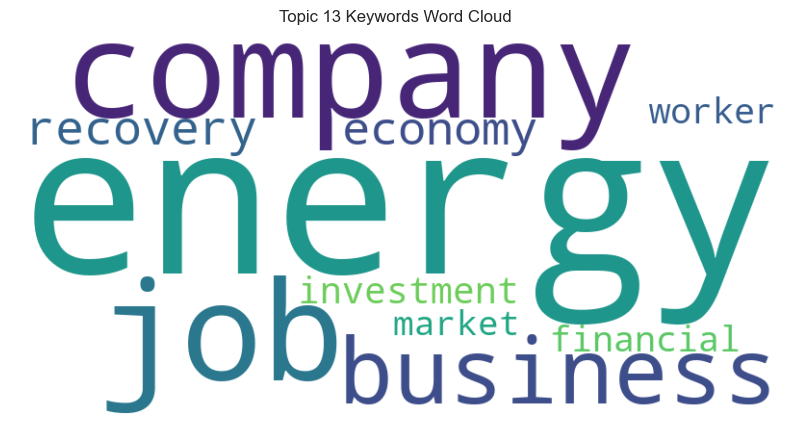

In [181]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Set the number of topics in your PAModel
num_topics = best_k2

# Iterate over each topic
for topic_idx in range(num_topics):
    # Create a dictionary of word-frequency pairs for the word cloud
    word_freq = {keyword: weight for keyword, weight in model.get_topic_words(topic_idx)}

    # Create a WordCloud object
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_freq)

    # Create a new figure and axis for the current topic's word cloud
    fig, ax = plt.subplots(figsize=(10, 5))
    ax.imshow(wordcloud, interpolation='bilinear')
    ax.set_title('Topic {} Keywords Word Cloud'.format(topic_idx))
    ax.axis('off')

    # Save the word cloud as an image file
    image_filename = 'topic_{}_wordcloud.png'.format(topic_idx)
    plt.savefig(image_filename)

    # Display the word cloud for the current topic
    plt.show()


In [20]:
# Top N Speeches per Topic 
id = 642
d = model.docs[id]
print(np.round(d.get_sub_topic_dist(),2))
print(data.iloc[id].content.replace(". ","\n"))

[0.   0.   0.   0.97 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.03
 0.  ]
Thank you 
  Thank you , very much 
 I accept 
 We 'll take it 
Well , we 're delighted to be back in Michigan 
And I want to thank you for that warm welcome today 
And we 're delighted to be here , and I can see from the enthusiasm in this crowd , as Dave says , this must be Bush-Cheney country 
 Now , it 's true Lynne has known me since I was 14 years old , but she wouldn 't go out with me until I was 17 
 I 'm not sure whether that was her choice , or her father 's choice 
 But I like to tell people we got married because Dwight Eisenhower got elected President of the United States 
Yeah 
Somebody here voted for him 
 But in those days , I was a youngster living in Lincoln , Nebraska 
Dad worked for the Soil Conservation Service 
Eisenhower got elected , reorganized the government , Dad got transferred to Casper , Wyoming , which is where I met Lynne 
We grew up together , went to high school together , an

Saving the model to ensure the possibility of reproducing the output

In [73]:
model.save("/Users/laurachristoph/Library/CloudStorage/OneDrive-UniversitätZürichUZH/CL/03_F23_TextAnalytics/03_F23_TextAnalytics_TopicModel_Speeches/f23_textanalytics_topicmodeling/model2.bin")

In [182]:
def find_topic_dist(content):
    try:
        # Find the ID with the same content as the speech
        id = data[data['content'] == content].index[0]
        d = model.docs[id]
        return np.round(d.get_sub_topic_dist(), 2)
    except IndexError:
        return None

# Apply the function to every row of the DataFrame
data['topic_dist'] = data['content'].apply(find_topic_dist)



## display(data)

In [183]:
filtered_df = data[data['topic_dist'].apply(lambda x: len(x) > 0)]
display(filtered_df)

,party,fileid,name,content,year,topic_idx,topic_dist
0,rep,akeyes-95,Alan_Keyes,We who are Christians usually think about Chri...,1995,2,"[0.0, 0.01, 0.01, 0.0, 0.0, 0.01, 0.0, 0.87, 0..."
1,rep,akeyes-98,Alan_Keyes,It is a very great honor and pleasure for me t...,1998,2,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.85, 0.0,..."
2,rep,akeyes1-2-00,Alan_Keyes,Thank you . Praise God . Thank you very much ....,2000,2,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.06, 0.0, 0.75, 0.0..."
3,rep,akeyes1-6-96,Alan_Keyes,Thank you . Thank you . Praise God . Thank you...,1996,2,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.8, 0.04,..."
4,rep,akeyes1-6-98,Alan_Keyes,"Thank you very much , God bless you . Unaccust...",1998,2,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.01, 0.0, 0.91, 0.0..."
...,...,...,...,...,...,...,...
3242,dem,wjclinton9-8-00a,Bill_Clinton,"Thank you . Good afternoon , welcome to the Wh...",2000,14,"[0.03, 0.11, 0.0, 0.1, 0.0, 0.01, 0.0, 0.07, 0..."
3243,dem,wjclinton9-8-00b,Bill_Clinton,"Thank you , thanks for the tie . You know , I ...",2000,4,"[0.07, 0.01, 0.0, 0.0, 0.0, 0.02, 0.01, 0.01, ..."
3244,dem,wjclinton9-8-96,Bill_Clinton,Thank you very much . I am delighted to be her...,1996,4,"[0.01, 0.03, 0.08, 0.0, 0.11, 0.0, 0.0, 0.05, ..."
3245,dem,wjclinton9-9-96b,Bill_Clinton,"Ladies and gentlemen , welcome to the White Ho...",1996,7,"[0.08, 0.11, 0.0, 0.0, 0.0, 0.0, 0.04, 0.03, 0..."


In [205]:
topic_frames = []

for k in range(best_k2):
    print('Topic #{}'.format(k))
    print("\t", ["%s * %.4f" % (w,f) for w, f in model.get_topic_words(k)])
    # Store the words in a list
    topic_words = {w for w,f in model.get_topic_words(k)}

    # Add the topic to the dictionary
    topics_dict[k] = topic_words

Topic #0
	 ['teacher * 0.0112', 'student * 0.0103', 'school * 0.0095', 'education * 0.0064', 'science * 0.0061', 'college * 0.0053', 'classroom * 0.0042', 'math * 0.0038', 'graduate * 0.0038', 'university * 0.0035']
Topic #1
	 ['israel * 0.0055', 'peace * 0.0054', 'democracy * 0.0052', 'europe * 0.0050', 'trade * 0.0047', 'africa * 0.0047', 'nato * 0.0044', 'nuclear * 0.0042', 'global * 0.0041', 'minister * 0.0039']
Topic #2
	 ['inflation * 0.0066', 'soviet * 0.0061', 'liberal * 0.0055', 'opponent * 0.0052', 'taxis * 0.0049', 'mondale * 0.0043', 'spending * 0.0043', 'nicaragua * 0.0041', 'rate * 0.0039', 'sandinista * 0.0030']
Topic #3
	 ['iraq * 0.0116', 'terrorist * 0.0114', 'military * 0.0066', 'enemy * 0.0061', 'iraqi * 0.0059', 'terror * 0.0054', 'veteran * 0.0053', 'afghanistan * 0.0050', 'attack * 0.0050', 'force * 0.0041']
Topic #4
	 ['kid * 0.0091', 'healthy * 0.0076', 'team * 0.0072', 'food * 0.0065', 'coach * 0.0061', 'game * 0.0050', 'player * 0.0043', 'obesity * 0.0041', '

In [224]:
data["content"][460]

"Good morning . Thank you very much , Dr . Siregar , for that wonderful introduction . It 's an introduction I 'll never quite forget , so thank you very much for that .  I want to thank you also for this opportunity to address the Indonesia World Affairs Council . Gatherings of this kind of people who are interested in foreign affairs from all walks of life are extremely important to the functioning of democracy and I congratulate you and your board and your patrons for the excellent work that this council does . It 's a pleasure to be here in Jakarta . Yesterday , I had the honor of meeting with President Yudhoyono . He shared with me his vision of a united and successful and democratic Indonesia -- a vision that is increasingly coming true under his leadership . Today , more Indonesians than ever enjoy lives of peace and opportunity and freedom . And the United States wants to help you expand democracy 's benefits to every citizen in this country . The United States has been a Pacif

## One frame per topic:

In [185]:
import os

topic_frames = []

# Iterate over the topics
for k in range(best_k2):
    # Create a new data frame for the current topic
    topic_df_name = 'df_topic_{}'.format(k)
    topic_df = data[data['topic_dist'].apply(lambda x: x is not None and x[k] > 0)].copy()
    topic_df['weight'] = topic_df['topic_dist'].apply(lambda x: x[k])
    topic_df = topic_df[['weight', 'party', 'content', 'year']]
    globals()[topic_df_name] = topic_df
    topic_frames.append(globals()[topic_df_name])

    # Save the topic data frame as a CSV file
    file_name = '{}.csv'.format(topic_df_name)
    file_path = os.path.join(os.getcwd(), file_name)
    topic_df.to_csv(file_path, index=False)


In [186]:
topic_frames[2]
    

,weight,party,content,year
0,0.01,rep,We who are Christians usually think about Chri...,1995
6,0.10,rep,Good evening . Sorry I 'm a little late--subje...,2000
7,0.01,rep,Thank you . . . Thank you . . . Thank yo...,1995
8,0.02,rep,God Bless you . Praise God ! Thank you . Prais...,1996
9,0.03,rep,Thank you . Here we are . Praise God . Good mo...,2000
...,...,...,...,...
3224,0.02,dem,"Thank you very much , Mr . Vice President . Th...",1994
3225,0.02,dem,"Thank you very much , ladies and gentlemen . I...",1999
3232,0.01,dem,"First of all , I want to thank all the people ...",1995
3236,0.01,dem,"Thank you so much . Thank you . Thank you , Se...",1994


In [188]:
shrinked_topics = []

# Iterate over the topic frames
for topic_df in topic_frames:
    # Group the rows by party and year, and calculate the sum of weights
    shrinked_df = topic_df.groupby(['party', 'year']).agg({'weight': 'sum'}).reset_index()

    # Add the shrinked data frame to the list
    shrinked_topics.append(shrinked_df)


In [99]:
shrinked_topics[0]

,party,year_formatted,weight
0,dem,1900-01-01,6.090000
1,dem,1901-01-01,0.740000
2,dem,1902-01-01,0.410000
3,dem,1903-01-01,1.800000
4,dem,1904-01-01,3.660000
5,dem,1905-01-01,1.500000
6,dem,1906-01-01,1.050000
7,dem,1907-01-01,0.380000
8,dem,1909-01-01,56.810001
9,dem,1910-01-01,63.180000


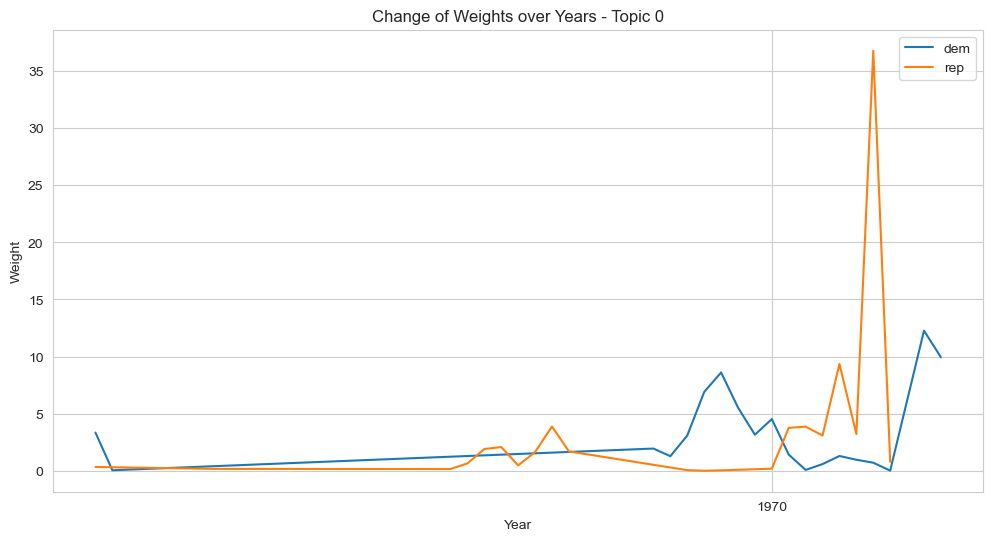

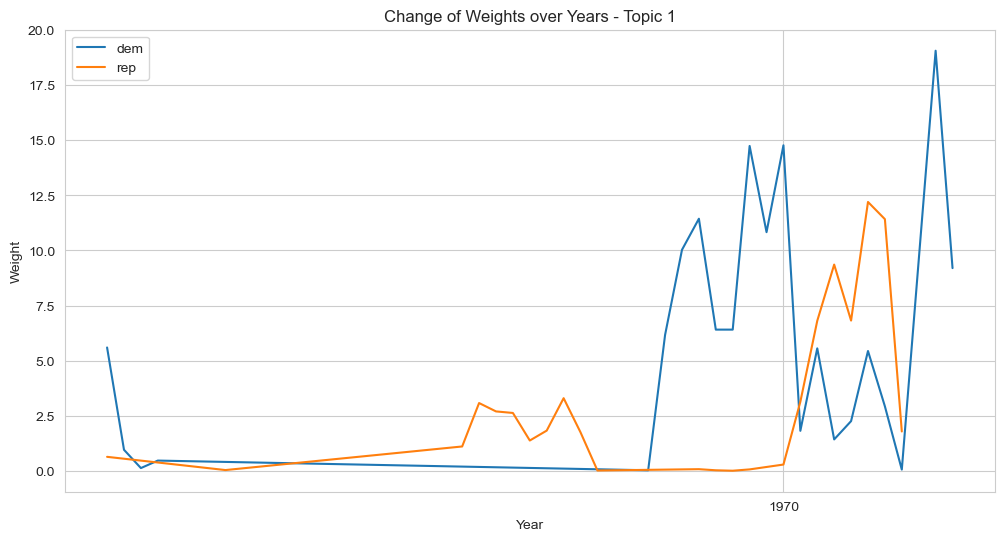

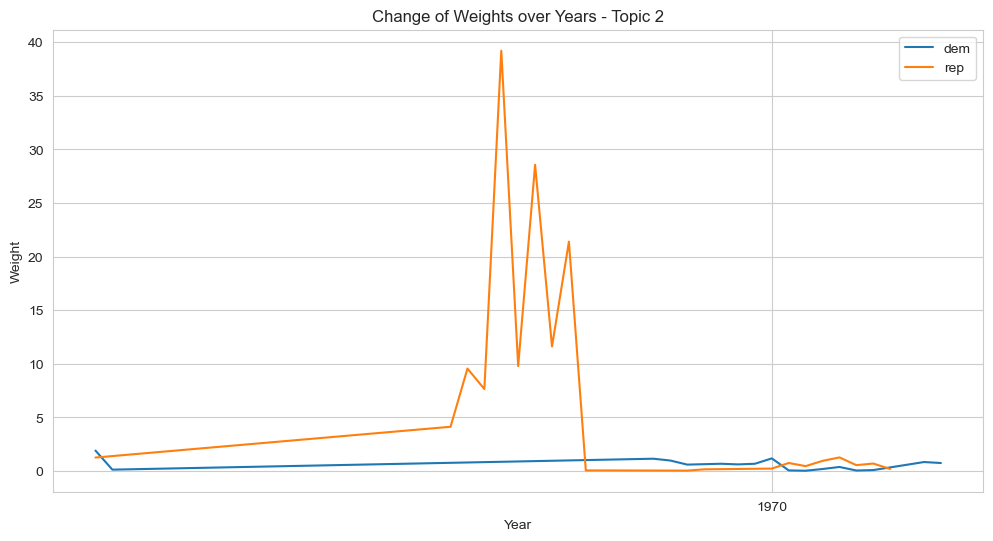

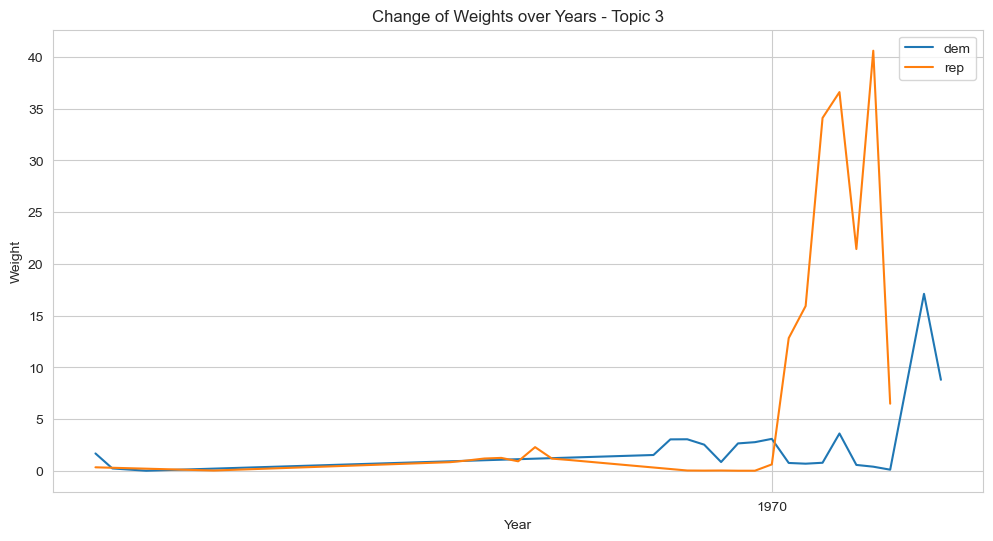

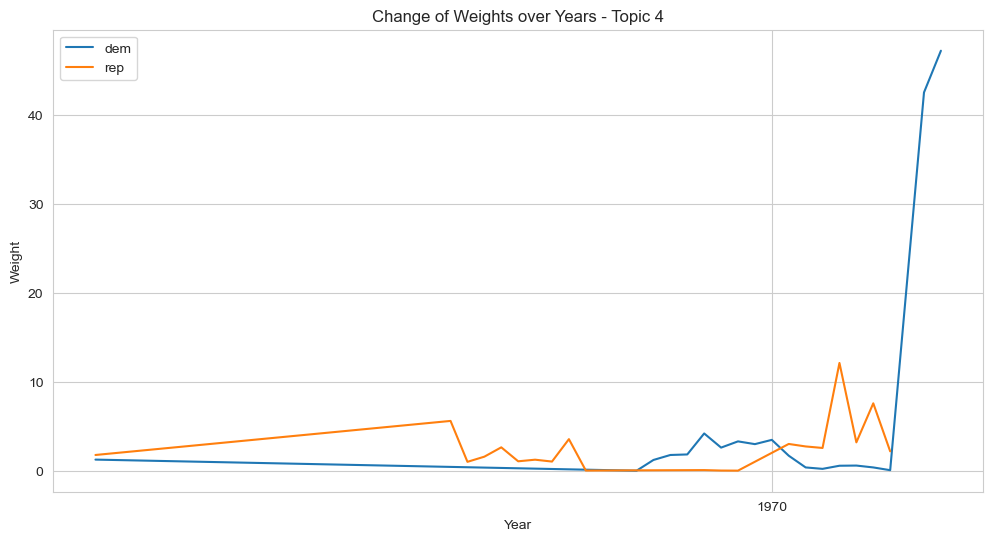

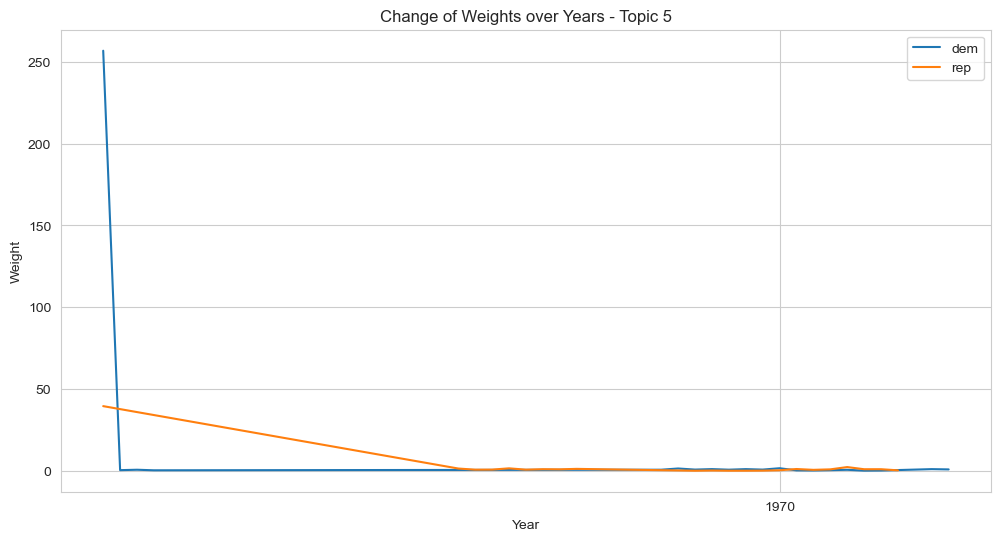

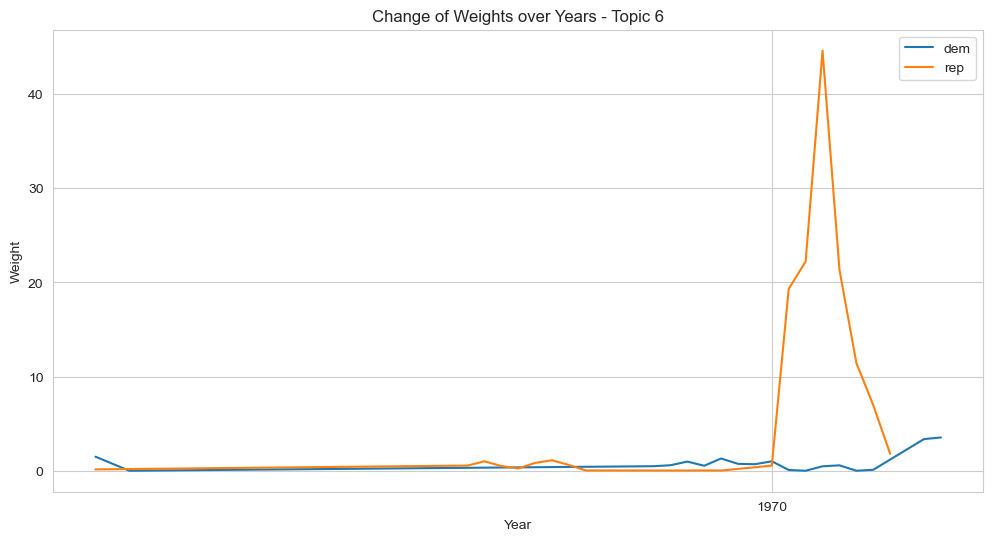

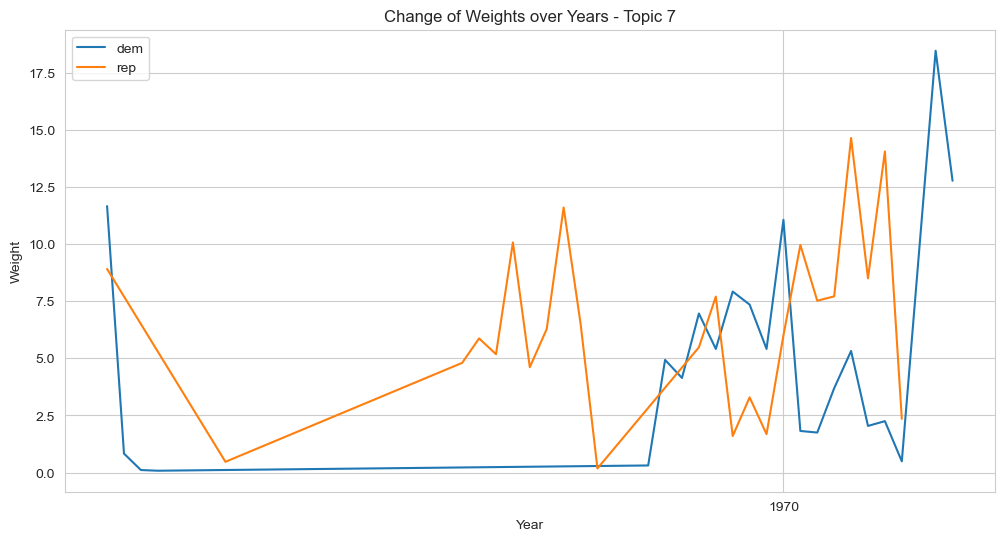

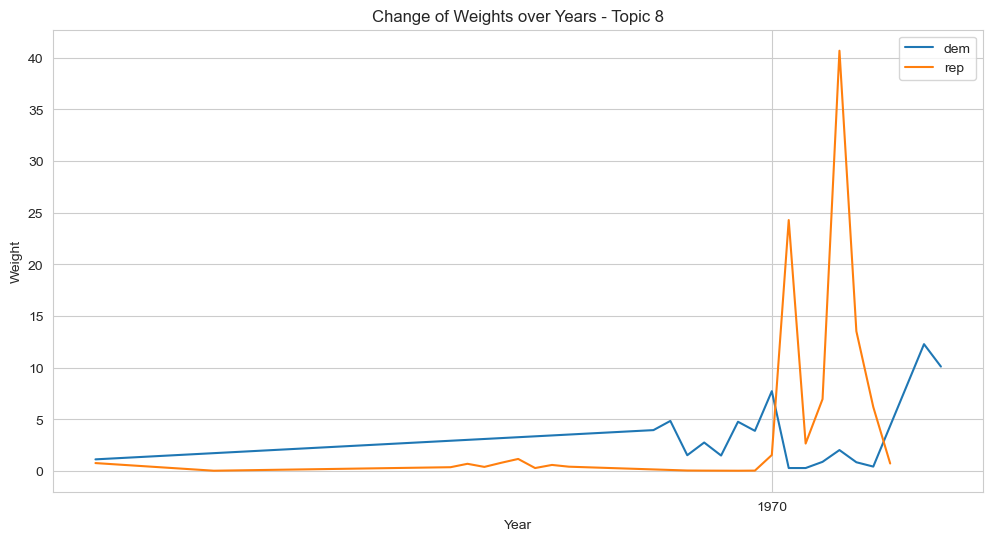

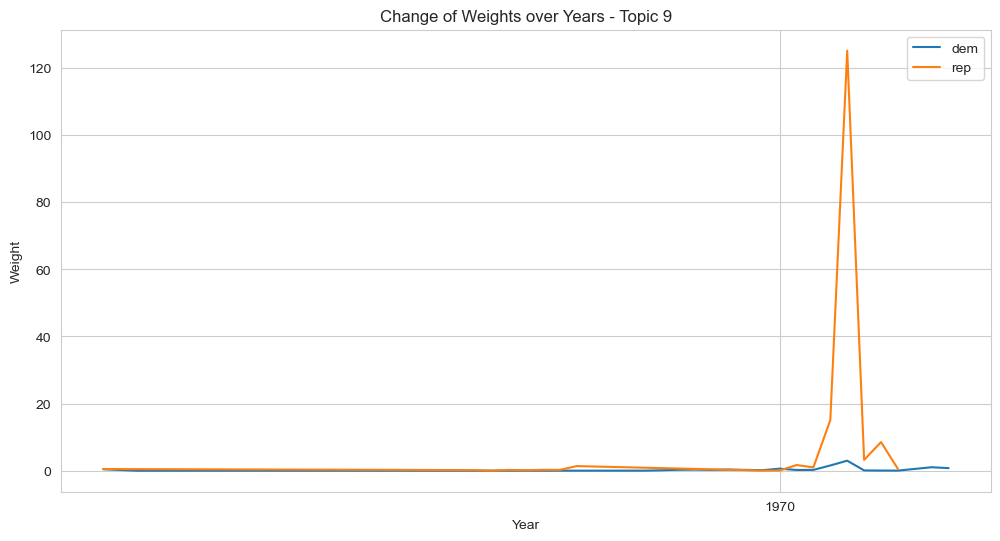

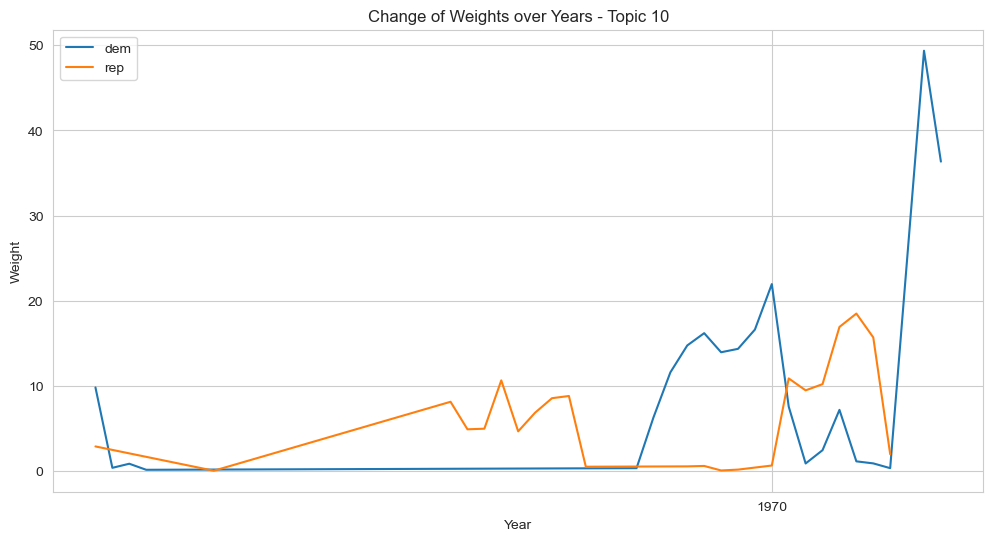

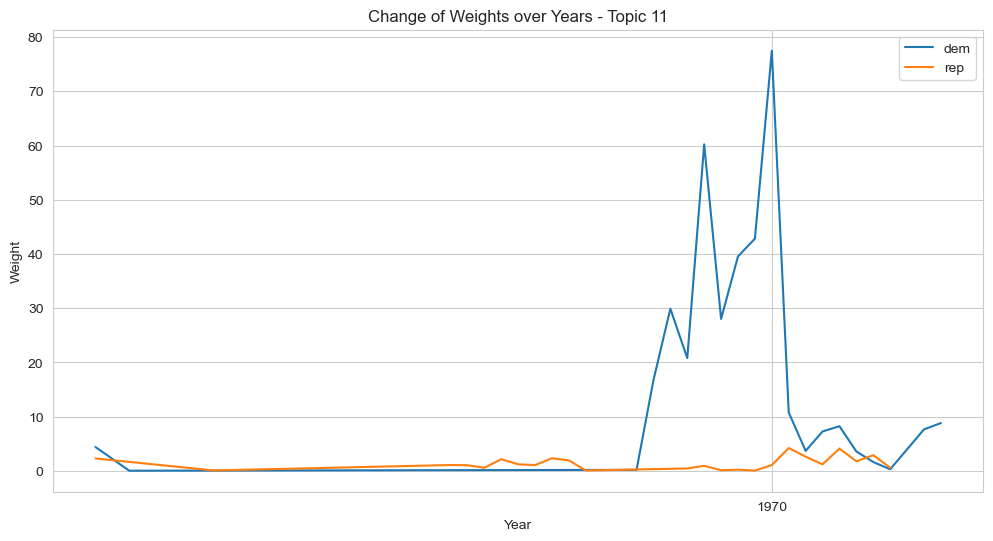

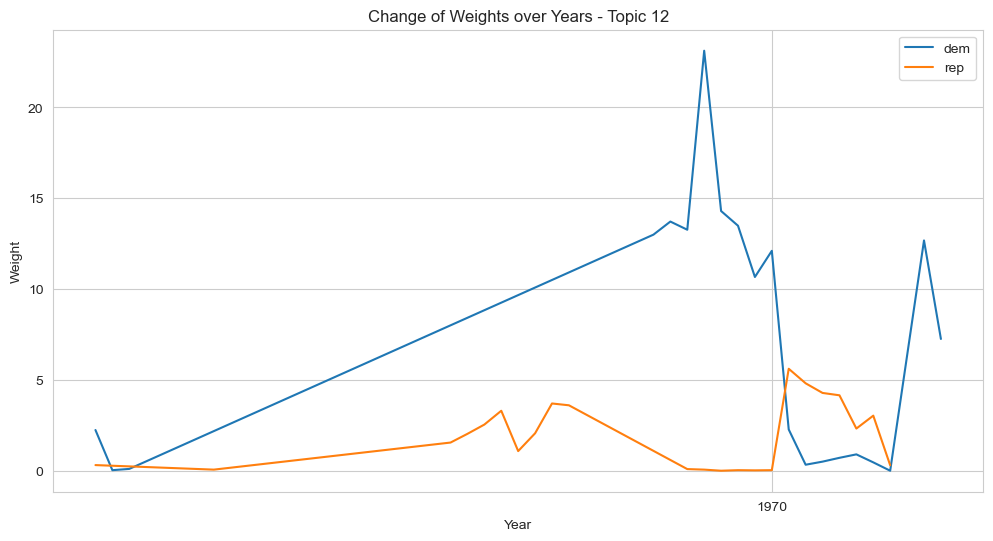

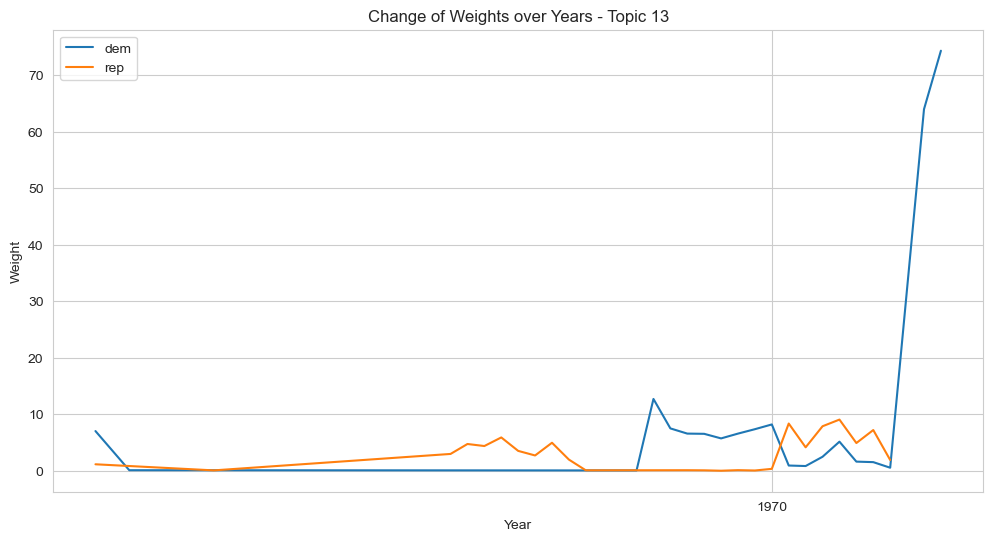

In [190]:
# Iterate over the shrinked topics
for topic_idx, shrinked_df in enumerate(shrinked_topics):
    # Convert 'year_formatted' column to datetime data type
    shrinked_df['year'] = pd.to_datetime(shrinked_df['year'])
    
    # Sort the DataFrame by date
    shrinked_df = shrinked_df.sort_values('year')

    # Create a new figure and axis for the current topic
    fig, ax = plt.subplots(figsize=(12, 6))  # Set the figsize to double the width

    # Get the topic dataframe details
    topic_df_name = 'df_topic_{}'.format(topic_idx)
    weights = shrinked_df['weight']

    # Get the unique party values
    parties = shrinked_df['party'].unique()

    # Plot the line graph for each party
    for party in parties:
        party_data = shrinked_df[shrinked_df['party'] == party]
        ax.plot(party_data['year'], party_data['weight'], label=party)

    # Set the title and labels for the current topic
    ax.set_title('Change of Weights over Years - Topic {}'.format(topic_idx))
    ax.set_xlabel('Year')
    ax.set_ylabel('Weight')

    # Add a legend for the current topic
    ax.legend()

    # Save the plot as an image file
    plot_filename = 'topic_{}_plot.png'.format(topic_idx)
    plt.savefig(plot_filename)

    # Display the plot
    plt.show()


## Adding one column per topic:

In [193]:
# Create new columns for each topic
for i in range(14):
    col_name = f"topic_{i}"
    data[col_name] = data['topic_dist'].apply(lambda x: float(x[i]))


In [194]:
display(data)

,party,fileid,name,content,year,topic_idx,topic_dist,topic_0,topic_1,topic_2,...,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,topic_10,topic_11,topic_12,topic_13
0,rep,akeyes-95,Alan_Keyes,We who are Christians usually think about Chri...,1995,2,"[0.0, 0.01, 0.01, 0.0, 0.0, 0.01, 0.0, 0.87, 0...",0.00,0.01,0.01,...,0.00,0.01,0.00,0.87,0.00,0.00,0.09,0.00,0.00,0.01
1,rep,akeyes-98,Alan_Keyes,It is a very great honor and pleasure for me t...,1998,2,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.85, 0.0,...",0.00,0.00,0.00,...,0.00,0.00,0.00,0.85,0.00,0.00,0.05,0.07,0.02,0.01
2,rep,akeyes1-2-00,Alan_Keyes,Thank you . Praise God . Thank you very much ....,2000,2,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.06, 0.0, 0.75, 0.0...",0.00,0.00,0.00,...,0.00,0.06,0.00,0.75,0.00,0.05,0.08,0.04,0.00,0.00
3,rep,akeyes1-6-96,Alan_Keyes,Thank you . Thank you . Praise God . Thank you...,1996,2,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.8, 0.04,...",0.00,0.00,0.00,...,0.00,0.00,0.00,0.80,0.04,0.00,0.02,0.14,0.00,0.00
4,rep,akeyes1-6-98,Alan_Keyes,"Thank you very much , God bless you . Unaccust...",1998,2,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.01, 0.0, 0.91, 0.0...",0.00,0.00,0.00,...,0.00,0.01,0.00,0.91,0.00,0.00,0.07,0.00,0.00,0.01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3242,dem,wjclinton9-8-00a,Bill_Clinton,"Thank you . Good afternoon , welcome to the Wh...",2000,14,"[0.03, 0.11, 0.0, 0.1, 0.0, 0.01, 0.0, 0.07, 0...",0.03,0.11,0.00,...,0.00,0.01,0.00,0.07,0.00,0.00,0.54,0.06,0.07,0.00
3243,dem,wjclinton9-8-00b,Bill_Clinton,"Thank you , thanks for the tie . You know , I ...",2000,4,"[0.07, 0.01, 0.0, 0.0, 0.0, 0.02, 0.01, 0.01, ...",0.07,0.01,0.00,...,0.00,0.02,0.01,0.01,0.00,0.00,0.04,0.74,0.05,0.05
3244,dem,wjclinton9-8-96,Bill_Clinton,Thank you very much . I am delighted to be her...,1996,4,"[0.01, 0.03, 0.08, 0.0, 0.11, 0.0, 0.0, 0.05, ...",0.01,0.03,0.08,...,0.11,0.00,0.00,0.05,0.00,0.00,0.12,0.52,0.07,0.00
3245,dem,wjclinton9-9-96b,Bill_Clinton,"Ladies and gentlemen , welcome to the White Ho...",1996,7,"[0.08, 0.11, 0.0, 0.0, 0.0, 0.0, 0.04, 0.03, 0...",0.08,0.11,0.00,...,0.00,0.00,0.04,0.03,0.00,0.00,0.44,0.05,0.25,0.00


### Adding the information to a new csv file for further data analysis

In [195]:
# Create a new DataFrame with selected columns
new_data = data[['party', 'fileid', 'name', 'content', 'year'] + [f"topic_{i}" for i in range(14)]].copy()

# Save the new DataFrame as a CSV file
new_data.to_csv('data_with_topic_weights.csv', index=False)